# Experiments to draw from cast

How to draw players from cast, randomly but taking into account how much they played so far.

Note: if output includes lots of comment, modify the `@monitor_fn` decorator

In [18]:
from pathlib import Path
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
if not (Path.cwd()/'gamesession.py').exists():  
    print('changing cwd')  
    os.chdir('..')
    Path.cwd()

from gamesession import GameSession

In [20]:
session = GameSession()

In [21]:
session.show_cast()

Player Info: 
    name           : Chris
    nbr_games_played: 0
    hosting_inclusion_list: []
    hosting_exclusion_list: []
    game_exclusion_list: []

Player Info: 
    name           : Etienne
    nbr_games_played: 0
    hosting_inclusion_list: []
    hosting_exclusion_list: []
    game_exclusion_list: []

Player Info: 
    name           : Knick
    nbr_games_played: 0
    hosting_inclusion_list: ['Story, Story, Die!']
    hosting_exclusion_list: []
    game_exclusion_list: []

Player Info: 
    name           : Serena
    nbr_games_played: 0
    hosting_inclusion_list: []
    hosting_exclusion_list: []
    game_exclusion_list: []

Player Info: 
    name           : Yirong
    nbr_games_played: 0
    hosting_inclusion_list: []
    hosting_exclusion_list: []
    game_exclusion_list: []



## Experiment with drawing players

Options 1:

- weights $P_i = \large \frac{\text{factor}}{\text{sum of plays} + 1}$
- apply softmax to create probability, but exluding players not to play in that game
- randomly draw n players from that probability

Options 2:

- weights $P_i =  \exp{(- \lambda \times \text{ sum of plays})}$
- filtering out any player to exclude
- apply softmax to create probability, but exluding players not to play in that game
- randomly draw n players from that probability

The analysis below shows that the best is to use the 'linear' method with a factor = 25 to make probability of beeing picked for those players who played more than others much lower.

In [22]:
session = GameSession()
player_names = np.array([g.name for g in session.games])
n = np.argwhere(player_names=='Sure Ding').item()
session.games[n].name

'Sure Ding'

In [23]:
def test_pick(method, factor=1, l=0.5):
    results = pd.DataFrame(columns=[player.name for player in session.cast])
    total = 5_000
    for i in range(total):
        idxs, names = session.pick_players(session.games[n], method=method, factor=factor, l=l)
        played = np.zeros(session.nbr_players)
        played[idxs] = 1
        results.loc[i, :] = played
    results = results / total
    results.sum(axis=0).plot(kind='bar', title=f"{method}, factor={factor}, l={l}. playersgame: {results.sum().sum():.0f}")
    print(f"{results.sum(axis=0).min():.5f}, {results.sum(axis=0).max():.5f}")
    plt.show()

## Linear with different factors

In [24]:
for nbr_played, player in zip([0, 1, 2, 3, 5], session.cast):
    player.nbr_games_played = nbr_played
[(p.name, p.nbr_games_played) for p in session.cast]

[('Chris', 0), ('Etienne', 1), ('Knick', 2), ('Serena', 3), ('Yirong', 5)]

0.58920, 0.61000


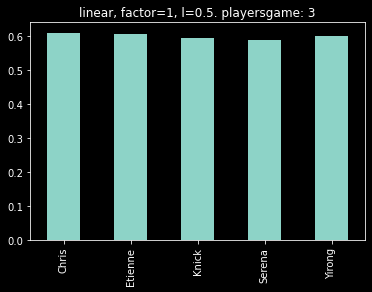

0.58340, 0.61440


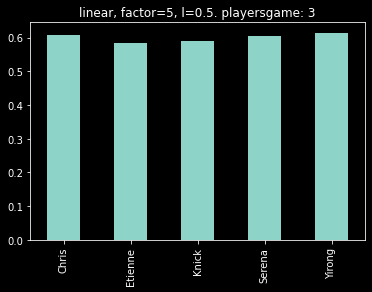

0.59020, 0.61080


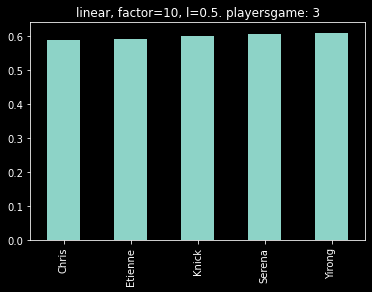

0.59600, 0.60440


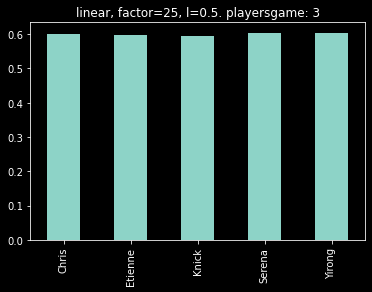

0.58980, 0.61480


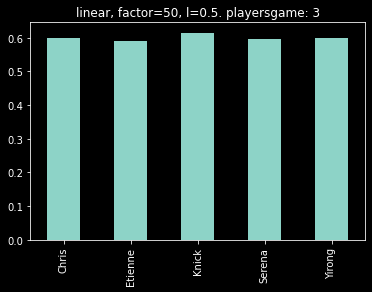

In [25]:
test_pick(method='linear', factor=1)
test_pick(method='linear', factor=5)
test_pick(method='linear', factor=10)
test_pick(method='linear', factor=25)
test_pick(method='linear', factor=50)

[('Chris', 3), ('Etienne', 3), ('Knick', 5), ('Serena', 5), ('Yirong', 6)]

0.58840, 0.60900


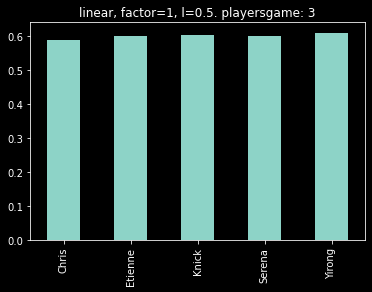

0.59260, 0.60560


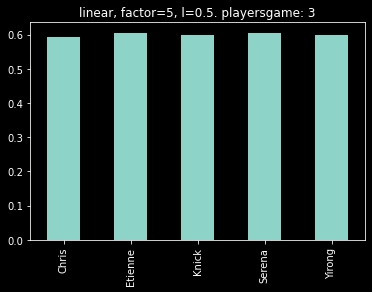

0.59580, 0.60780


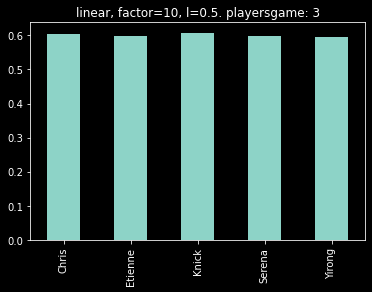

0.59420, 0.60520


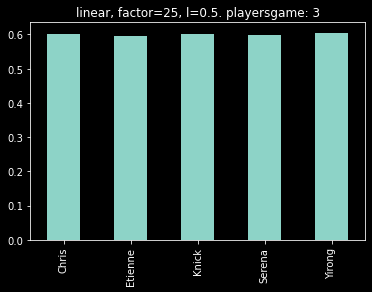

0.58960, 0.61320


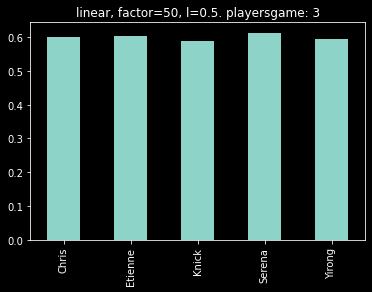

In [26]:
for nbr_played, player in zip([3, 3, 5, 5, 6], session.cast):
    player.nbr_games_played = nbr_played

display([(p.name, p.nbr_games_played) for p in session.cast])

test_pick(method='linear', factor=1)
test_pick(method='linear', factor=5)
test_pick(method='linear', factor=10)
test_pick(method='linear', factor=25)
test_pick(method='linear', factor=50)

### Run several game sessions with linear method

Check that the number of player is balanced between players over may sessions

In [27]:
session = GameSession()
[(p.name, p.nbr_games_played) for p in session.cast]

[('Chris', 0), ('Etienne', 0), ('Knick', 0), ('Serena', 0), ('Yirong', 0)]

In [28]:
def run_game_set():
    session = GameSession()
    while True:
        session.pick_next_game()
        if session.current_game_idx is not None:
            game = session.games[session.current_game_idx]
            player_idxs, player_names = session.pick_players(game)
            # for player_idx in player_idxs:
            #     session.cast[player_idx].nbr_games_played += 1
        else: 
            # print('All games played')
            break
    return [p.nbr_games_played for p in session.cast]

run_game_set()

[15, 17, 16, 13, 12]

In [29]:
l = []
for i in range(1_000):
    l.append(run_game_set())
df = pd.DataFrame(data=l, columns=[p.name for p in session.cast])
df.describe()

,Chris,Etienne,Knick,Serena,Yirong
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,14.621000,14.572000,14.593000,14.619000,14.595000
std,1.078203,1.124313,1.120985,1.123878,1.064946
min,12.000000,12.000000,10.000000,11.000000,12.000000
25%,14.000000,14.000000,14.000000,14.000000,14.000000
50%,15.000000,15.000000,15.000000,15.000000,15.000000
75%,15.000000,15.000000,15.000000,15.000000,15.000000
max,18.000000,18.000000,19.000000,18.000000,18.000000


<AxesSubplot:>

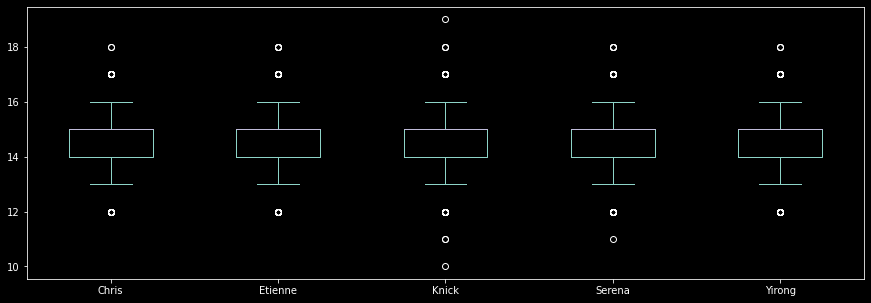

In [30]:
df.plot(kind='box', figsize=(15, 5))

## Exponential

In [10]:
for nbr_played, player in zip([0, 1, 2, 3, 4], session.cast):
    player.nbr_games_played = nbr_played

display([(p.name, p.nbr_games_played) for p in session.cast])

[('Chris', 0), ('Etienne', 1), ('Knick', 2), ('Serena', 3), ('Yirong', 4)]

0.59100, 0.61220


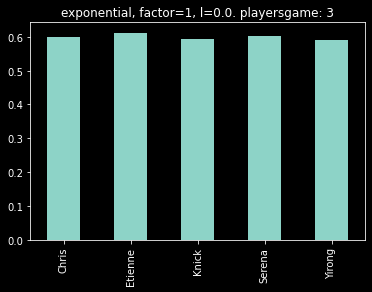

0.49220, 0.72600


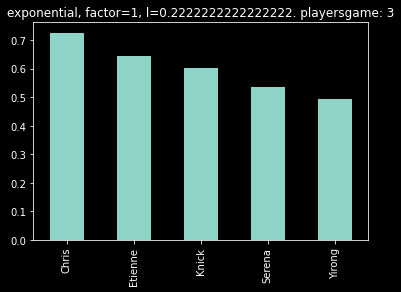

0.48820, 0.78300


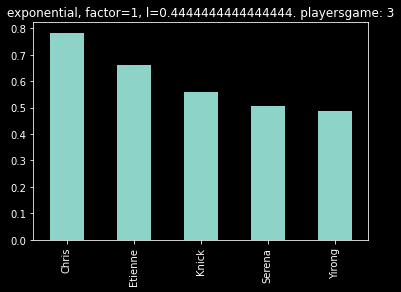

0.47440, 0.82580


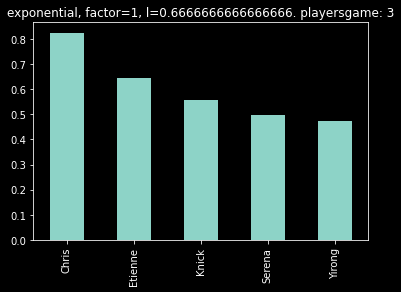

0.47060, 0.83100


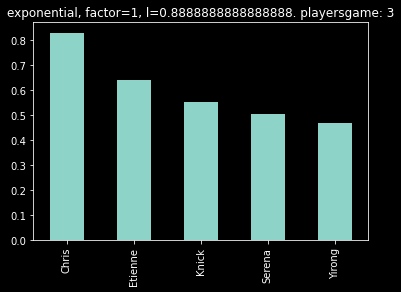

0.49200, 0.84020


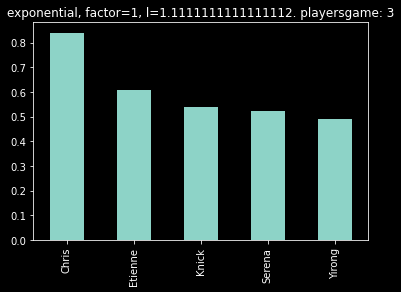

0.50320, 0.84900


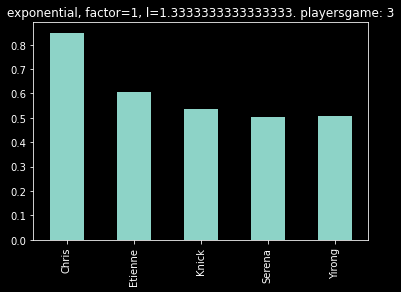

0.50880, 0.85820


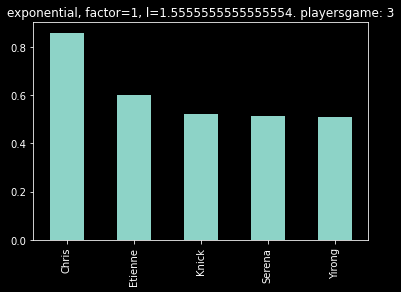

0.51860, 0.86360


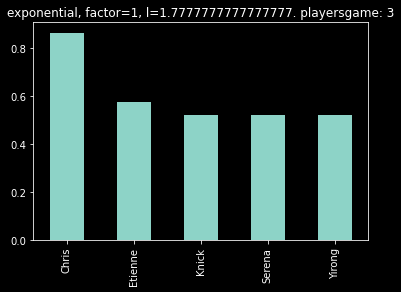

0.51360, 0.86000


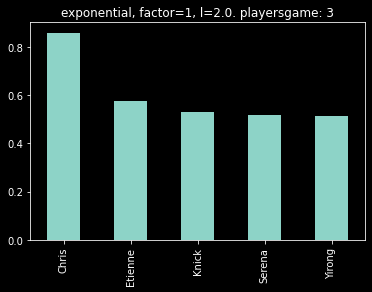

In [11]:
for l in np.linspace(0, 2, 10):
    test_pick(method='exponential', l=l)

[('Chris', 3), ('Etienne', 3), ('Knick', 5), ('Serena', 5), ('Yirong', 6)]

0.58880, 0.61280


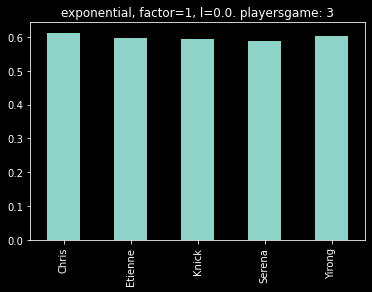

0.55500, 0.64960


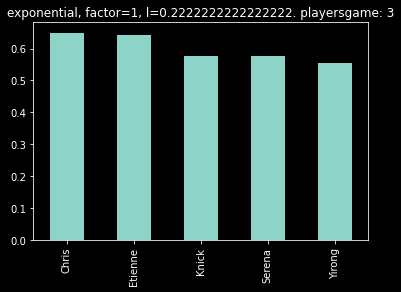

0.55460, 0.64880


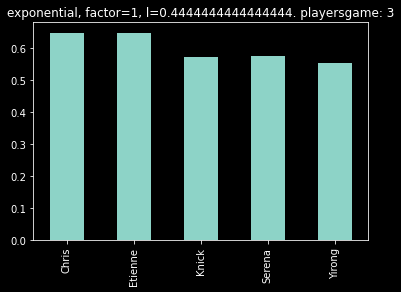

0.57060, 0.62860


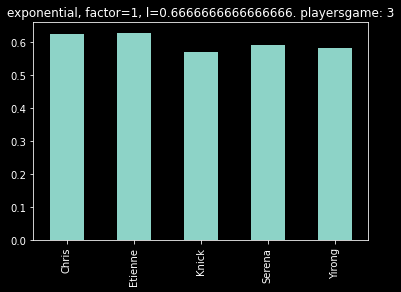

0.58100, 0.61780


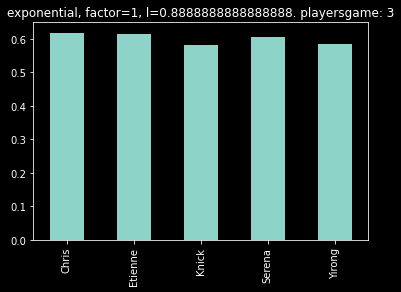

0.58240, 0.61080


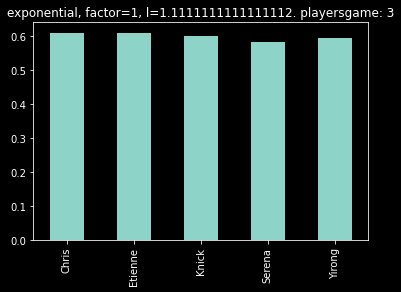

0.59680, 0.60760


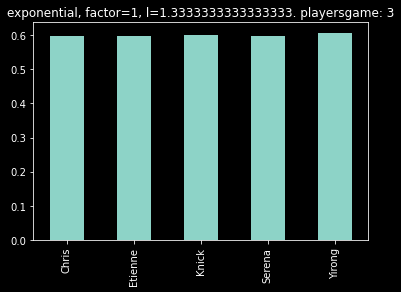

0.59140, 0.61060


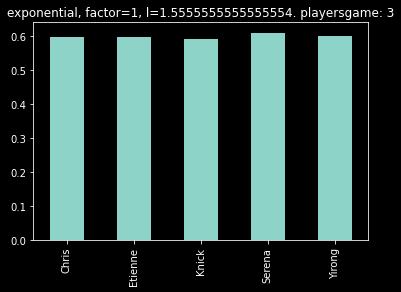

0.58840, 0.61180


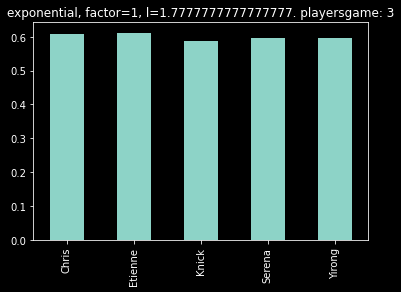

0.58620, 0.62000


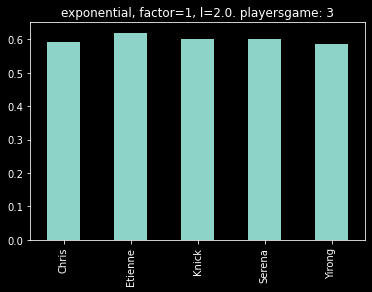

In [11]:
for nbr_played, player in zip([3, 3, 5, 5, 6], session.cast):
    player.nbr_games_played = nbr_played

display([(p.name, p.nbr_games_played) for p in session.cast])

for l in np.linspace(0, 2, 10):
    test_pick(method='exponential', l=l)